# Importing Libraries

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

# Data Fetching

In [11]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16],low_memory=False)
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19],low_memory=False)
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# A fast algorithm for Independent Component Analysis Decomposition

In [12]:
from sklearn.decomposition import PCA
import warnings
scaler_obj1=PCA()
scaler_obj2=PCA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)

# Parameter Tuning

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

def hyperparameterRF(x_train,y_train):
    random_grid = {'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)

    grid_result = MultiOutputRegressor(rf_random).fit(x_train, y_train)
    
    return grid_result.estimators_[0].best_params_
    

# Model

In [13]:
# Splitting Data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

model2=MultiOutputRegressor(RandomForestRegressor(max_depth=10,n_estimators=100, random_state=0))

#training the model
model_fit2=model2.fit(x_train,y_train)
print("Model training is Done!!")

filename2 = 'randomforest.sav'
pickle.dump(model_fit2, open(filename2, 'wb'))

Model training is Done!!


# Error Analysis

In [14]:
from sklearn import metrics
train_sizes=['NO2','O3','NO','CO','PM1','PM2.5','PM10']

#finding out the r2 score
y_train_pred2=model2.predict(x_train)
r2_train2=r2_score(y_train,y_train_pred2,multioutput='variance_weighted')

y_test_pred2=model2.predict(x_test)
r2_test2=r2_score(y_test,y_test_pred2,multioutput='variance_weighted')

print('r2 score on train data '+str(r2_train2))
print('r2 score on test data '+ str(r2_test2))

rf_mae=metrics.mean_absolute_error(y_test, y_test_pred2)
rf_mse=metrics.mean_squared_error(y_test, y_test_pred2)
rf_rmse=np.sqrt(metrics.mean_squared_error(y_test, y_test_pred2))
print('Mean Absolute Error:',rf_mae)
print('Mean Squared Error:',rf_mse )
print('Root Mean Squared Error:',rf_rmse)

r2 score on train data 0.7796755016302862
r2 score on test data -1504.1699651516203
Mean Absolute Error: 78.34981047307706
Mean Squared Error: 2154386819.476149
Root Mean Squared Error: 46415.37266333374


# Prediction of Particles value

In [15]:
import pickle
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X1,Y1,test_size=0.25,random_state=42)
loaded_model_fit7 = pickle.load(open("randomforest.sav", 'rb'))
y_test_pred=loaded_model_fit7.predict(x_test)
print("Predicted :\n",y_test_pred)
print("\n")
r2_test=r2_score(y_test,y_test_pred,multioutput='variance_weighted')
print("R2 Score : ",r2_test)

Predicted :
 [[-6.13377212e+01  2.62372311e+01  1.44247570e+02 ... -3.08748211e+01
  -4.35041804e-01  3.30102304e-01]
 [-4.88784351e+01 -4.47399358e+01  8.68685970e+01 ...  4.94264298e+01
  -2.05818270e-01 -4.48266445e-01]
 [-5.58662891e+01 -2.33405058e+01 -4.98187831e+02 ... -1.63478747e+01
  -5.01127152e-02  6.73247551e-02]
 ...
 [-8.19468933e+01 -2.56446998e+01 -4.99696879e+02 ...  5.73090089e+01
  -8.02071342e-01 -4.14399193e-01]
 [-4.46820981e+01  3.47574441e+01  3.75917712e+02 ... -1.87150551e+01
  -1.29502933e+00 -5.43979864e-01]
 [-9.07145143e+01 -3.04153017e+01  2.78122959e+02 ... -1.42817979e+01
   8.99995083e-01  2.41702260e-01]]


R2 Score :  -1504.1699651516203


In [16]:
x_test=scaler_obj1.inverse_transform(x_test)
y_test_pred=scaler_obj2.inverse_transform(y_test_pred)
y_test=scaler_obj2.inverse_transform(y_test)
pd.DataFrame(y_test_pred)

,0,1,2,3,4,5,6
0,77.673457,29.936401,-82.436148,582.147656,2.559635,3.077406,3.732914
1,6.629439,41.881744,0.132601,524.744566,43.018177,50.398926,54.451529
2,28.286644,35.047634,-17.980377,-60.302322,9.786999,11.395667,13.166551
3,51.532731,17.144039,-47.955955,721.039876,17.103469,19.489769,23.404276
4,10.504277,46.531687,4.883041,-94.818328,4.888863,5.714434,7.327009
...,...,...,...,...,...,...,...
432566,5.930090,51.165914,59.751949,-25.792479,4.730598,5.367404,7.272966
432567,84.133919,45.156743,-81.975425,427.752475,2.439523,2.964951,3.755032
432568,26.171713,8.950995,-32.860312,-61.816230,47.195250,55.358997,58.926409
432569,85.990539,46.653718,-87.453056,813.819913,9.667801,10.097644,10.790270


In [17]:
import datetime
from datetime import datetime
temp_arr=x_test[0:,1]
dates=list()
for i in range(0,len(temp_arr)):
    datetime_str=str(int(temp_arr[i]))
    datetime_str=datetime_str[0:6]
    if(datetime_str[4:6]=="00"):
        datetime_str=datetime_str[0:4]+'1'
    datetime_obj = datetime.strptime(datetime_str,"%y%m%d")
    dates.append(str(datetime_obj.date()))

In [18]:
import pandas as pd
df1=pd.DataFrame(y_test,index=dates,columns=['NO2','O3','NO','CO','PM1','PM2.5','PM10'])
df1.index.name="DATE"
print("Actual Values:")
df1

Actual Values:


,NO2,O3,NO,CO,PM1,PM2.5,PM10
DATE,,,,,,,
2019-06-04,81.999992,35.999981,-79.000076,706.000061,1.999994,2.420012,2.819992
2019-09-26,19.000008,50.000031,-7.999964,478.000000,10.170000,10.950006,12.669997
2019-05-14,58.000000,38.000008,-33.999943,-107.000092,27.400002,31.749990,41.180004
2019-04-18,82.999985,4.999985,-27.000103,1580.000244,39.410004,45.179993,50.160015
2019-08-31,5.000015,54.000038,-3.999901,-170.000153,6.900000,8.250006,9.109994
...,...,...,...,...,...,...,...
2019-03-29,-2.999992,104.000038,64.000160,28.999969,7.130006,7.980010,8.190001
2019-06-30,76.999992,39.999985,-81.000046,413.000000,1.939995,2.610010,4.119987
2019-10-02,21.000006,3.000038,-47.999969,-3.000000,52.910011,61.519974,67.230019


In [19]:
arr=["Y_Actual"]*25
temp_df1=df1.head(25)
temp_df1['Data']=arr
temp_df1.to_excel("randomforest_y_test.xlsx")
temp_df1

C:\Users\utkar\AppData\Local\Temp/ipykernel_9280/2047730199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df1['Data']=arr


,NO2,O3,NO,CO,PM1,PM2.5,PM10,Data
DATE,,,,,,,,
2019-06-04,81.999992,35.999981,-79.000076,706.000061,1.999994,2.420012,2.819992,Y_Actual
2019-09-26,19.000008,50.000031,-7.999964,478.000000,10.170000,10.950006,12.669997,Y_Actual
2019-05-14,58.000000,38.000008,-33.999943,-107.000092,27.400002,31.749990,41.180004,Y_Actual
2019-04-18,82.999985,4.999985,-27.000103,1580.000244,39.410004,45.179993,50.160015,Y_Actual
2019-08-31,5.000015,54.000038,-3.999901,-170.000153,6.900000,8.250006,9.109994,Y_Actual
2019-06-30,10.000008,34.000034,35.000114,51.999847,6.890001,8.320008,10.110000,Y_Actual
2019-07-27,24.000006,6.000038,-37.999950,-69.000092,18.180000,22.039999,23.079998,Y_Actual
2019-07-08,71.999992,11.999985,-93.000092,649.000000,3.119994,4.330011,6.959993,Y_Actual
2019-09-07,52.000000,66.000000,-73.000031,243.999954,20.639997,23.179996,23.709995,Y_Actual


In [20]:
import pandas as pd
df2=pd.DataFrame(y_test_pred,index=dates,columns=['NO2','O3','NO','CO','PM1','PM2.5','PM10'])
df2.index.name="DATE"
print("Predicted Values:")
df2

Predicted Values:


,NO2,O3,NO,CO,PM1,PM2.5,PM10
DATE,,,,,,,
2019-06-04,77.673457,29.936401,-82.436148,582.147656,2.559635,3.077406,3.732914
2019-09-26,6.629439,41.881744,0.132601,524.744566,43.018177,50.398926,54.451529
2019-05-14,28.286644,35.047634,-17.980377,-60.302322,9.786999,11.395667,13.166551
2019-04-18,51.532731,17.144039,-47.955955,721.039876,17.103469,19.489769,23.404276
2019-08-31,10.504277,46.531687,4.883041,-94.818328,4.888863,5.714434,7.327009
...,...,...,...,...,...,...,...
2019-03-29,5.930090,51.165914,59.751949,-25.792479,4.730598,5.367404,7.272966
2019-06-30,84.133919,45.156743,-81.975425,427.752475,2.439523,2.964951,3.755032
2019-10-02,26.171713,8.950995,-32.860312,-61.816230,47.195250,55.358997,58.926409


In [21]:
arr=["Y_Predicted"]*25
temp_df2=df2.head(25)
temp_df2['Data']=arr
temp_df2.to_excel("randomforest_y_test_pred.xlsx")
temp_df2

C:\Users\utkar\AppData\Local\Temp/ipykernel_9280/308882302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2['Data']=arr


,NO2,O3,NO,CO,PM1,PM2.5,PM10,Data
DATE,,,,,,,,
2019-06-04,77.673457,29.936401,-82.436148,582.147656,2.559635,3.077406,3.732914,Y_Predicted
2019-09-26,6.629439,41.881744,0.132601,524.744566,43.018177,50.398926,54.451529,Y_Predicted
2019-05-14,28.286644,35.047634,-17.980377,-60.302322,9.786999,11.395667,13.166551,Y_Predicted
2019-04-18,51.532731,17.144039,-47.955955,721.039876,17.103469,19.489769,23.404276,Y_Predicted
2019-08-31,10.504277,46.531687,4.883041,-94.818328,4.888863,5.714434,7.327009,Y_Predicted
2019-06-30,29.189243,45.726144,19.875660,-25.786655,6.014873,7.394586,9.617390,Y_Predicted
2019-07-27,27.110641,10.117954,-32.333741,-5.706961,17.093028,20.206457,22.158696,Y_Predicted
2019-07-08,73.557568,13.401593,-95.133436,614.603432,3.873415,4.582180,5.268942,Y_Predicted
2019-09-07,56.934339,35.726123,-64.600435,511.623408,73.096143,84.411692,88.050499,Y_Predicted


# y-test vs y-predict

Y_Test: [[ 81.99999    35.99998   -79.00008   ...   1.9999943   2.4200115
    2.819992 ]
 [ 19.000008   50.00003    -7.9999638 ...  10.17       10.950006
   12.669997 ]
 [ 58.         38.000008  -33.999943  ...  27.400002   31.74999
   41.180004 ]
 ...
 [ 21.000006    3.0000381 -47.99997   ...  52.91001    61.519974
   67.23002  ]
 [ 70.99999    39.99999   -87.00007   ...   7.5999937   8.020008
    8.019993 ]
 [ -8.999989   -4.9999237 -15.99999   ...   3.500001    4.2200146
    4.3899956]]
Y_Test_Predict: [[-6.13377212e+01  2.62372311e+01  1.44247570e+02 ... -3.08748211e+01
  -4.35041804e-01  3.30102304e-01]
 [-4.88784351e+01 -4.47399358e+01  8.68685970e+01 ...  4.94264298e+01
  -2.05818270e-01 -4.48266445e-01]
 [-5.58662891e+01 -2.33405058e+01 -4.98187831e+02 ... -1.63478747e+01
  -5.01127152e-02  6.73247551e-02]
 ...
 [-8.19468933e+01 -2.56446998e+01 -4.99696879e+02 ...  5.73090089e+01
  -8.02071342e-01 -4.14399193e-01]
 [-4.46820981e+01  3.47574441e+01  3.75917712e+02 ... -1.8715055

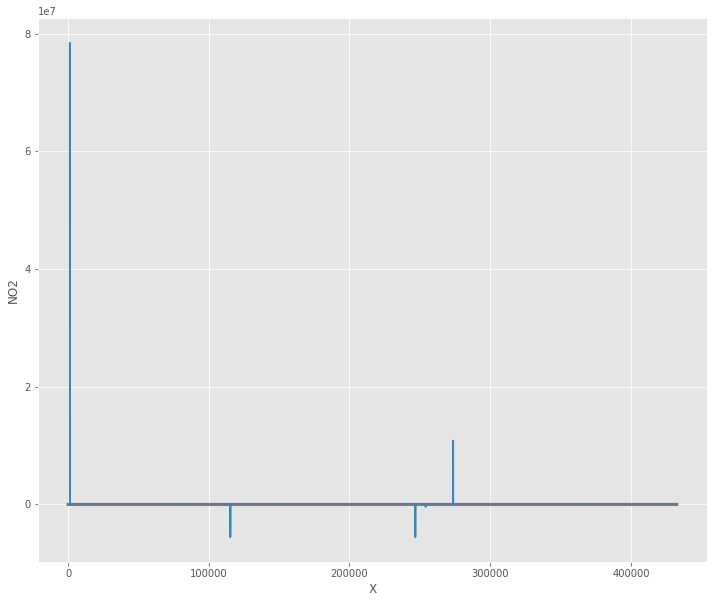

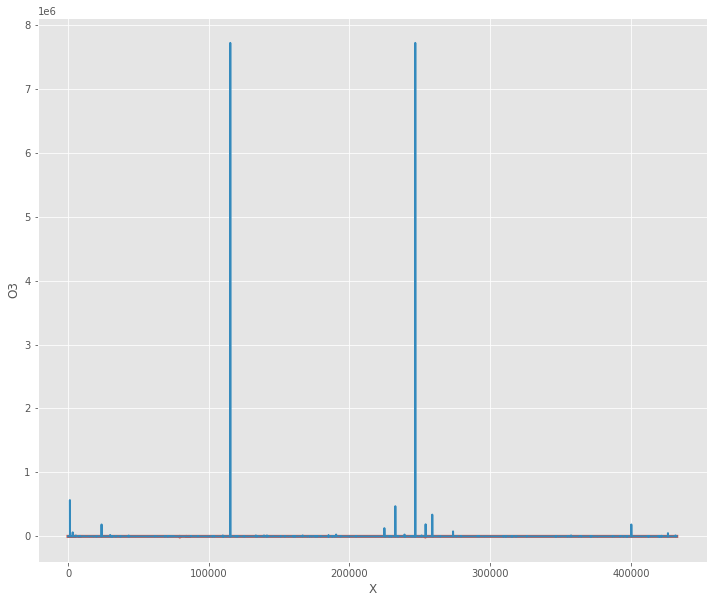

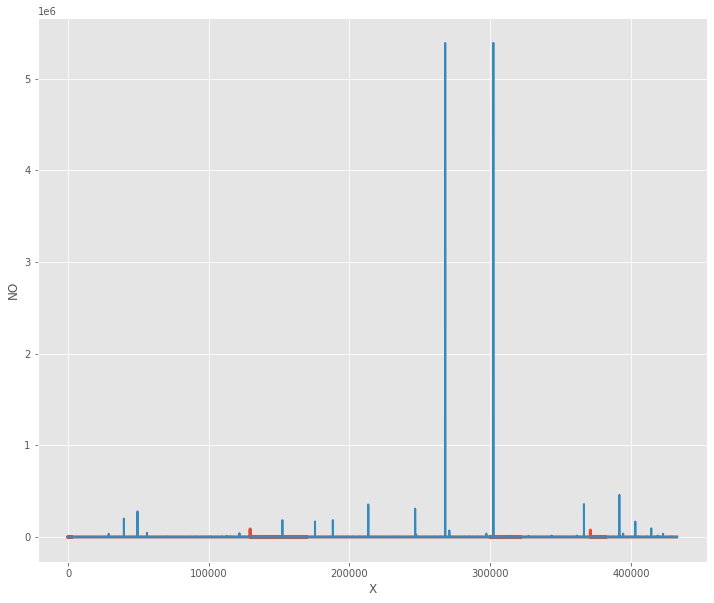

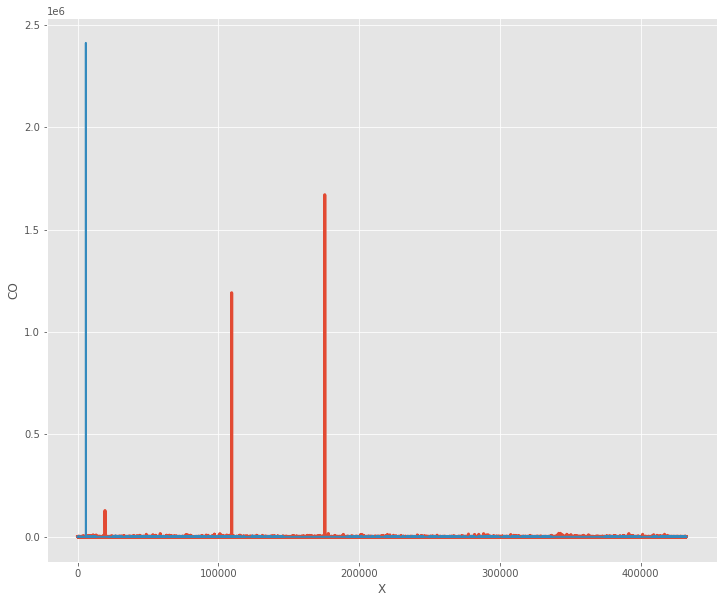

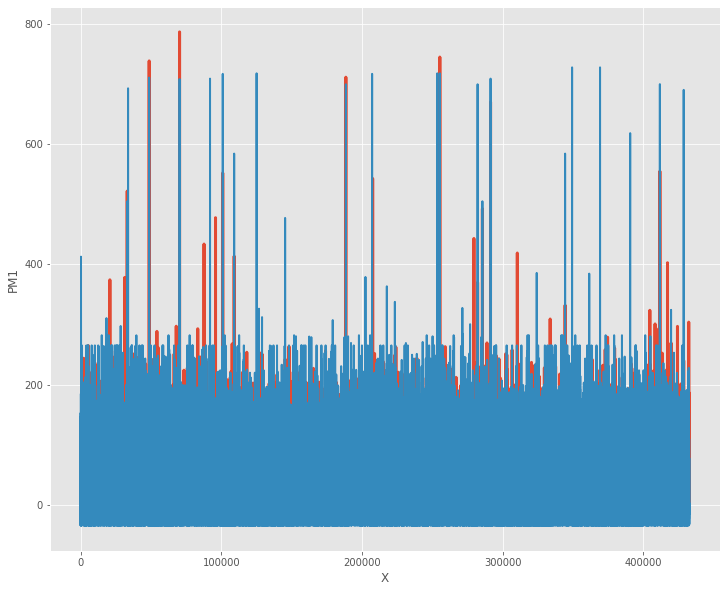

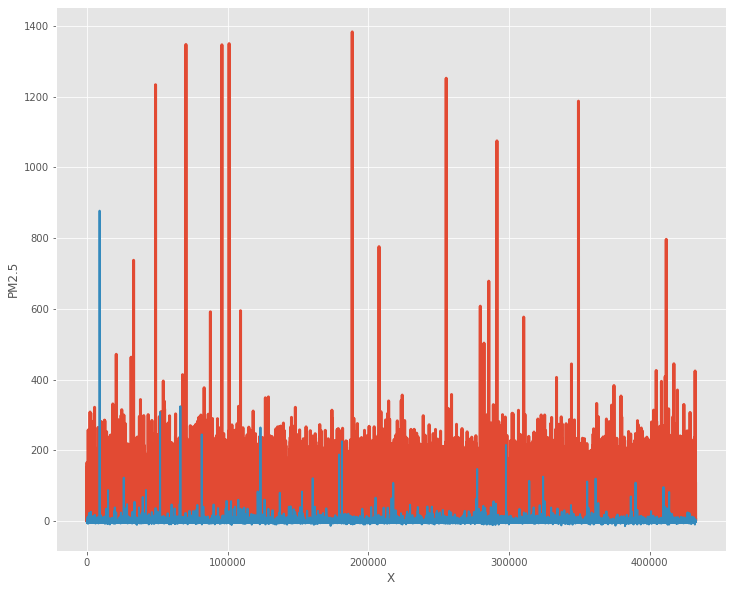

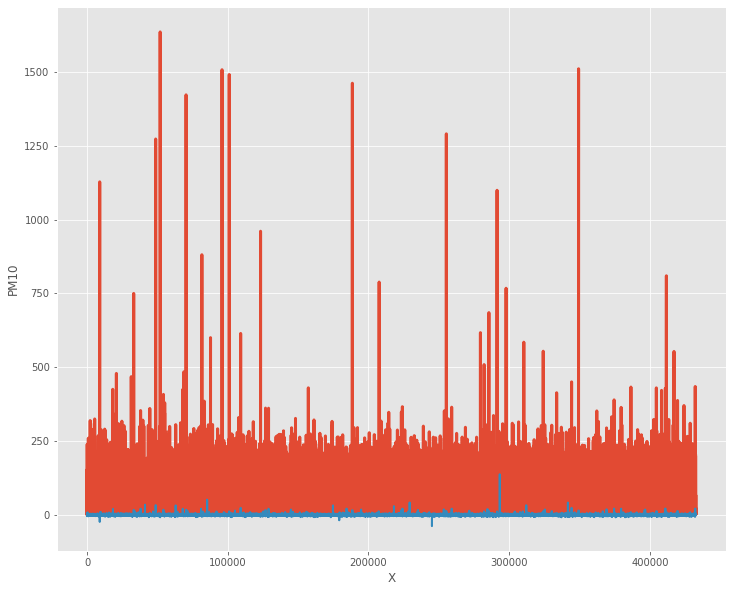

In [22]:
# printing y_test and y_test_predict
print("Y_Test:",y_test)
print("Y_Test_Predict:",y_test_pred2)

from matplotlib import style

style.use('ggplot')
for i in range(0,7):
  plt.figure(figsize=[12,10])
  plt.plot(y_test[:,i],linewidth=3, markersize=12)
  plt.plot(y_test_pred2[:,i],linewidth=2, markersize=12)
  plt.xlabel('X')
  plt.ylabel(train_sizes[i])
  plt.show()